Initialize the GCN network

In [ ]:
%load_ext autoreload
%autoreload 2

from model import GNLightning
import torch

if torch.cuda.is_available(): torch.cuda.empty_cache()

gnet = GNLightning.load_from_checkpoint(checkpoint_path=r"..\checkpoints\gnet_stage2.ckpt",
                                    d_model=128,
                                    lr=1e-3,
                                    batch_size=2,
                                    num_workers=0,
                                    train_path=r'..\misc\placeholder.jsonl',
                                    val_path=r'..\misc\placeholder.jsonl')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
gnet.to(device)
gnet.eval()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


GNLightning(
  (gnet): GraphNetwork(
    (conv1): GCNConv(8, 128)
    (conv2): GCNConv(128, 128)
    (lin1): Linear(in_features=256, out_features=128, bias=True)
    (lin_final): Linear(in_features=128, out_features=3, bias=True)
  )
  (criterion): NLLLoss()
)

Initialize the RCNN model

In [ ]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.transforms import functional as F
from PIL import Image

# Define the model architecture
def get_model():
    backbone = resnet_fpn_backbone('resnet50', pretrained=False)
    model = FasterRCNN(backbone, num_classes=2)  # Adjust the number of classes
    return model

# RCNN Forward Method
def rcnn_forward(image_path, checkpoint, confidence_threshold=0.5):
    """
    Perform a forward pass with FasterRCNN on the given image and return bounding boxes
    along with the image dimensions.

    Args:
        image_path (str): Path to the input image.
        checkpoint (str): Path to the model checkpoint file.

    Returns:
        tuple: (bboxes, torch.tensor([image_width, image_height]))
    """
    # Load model
    model = get_model()
    checkpoint_data = torch.load(checkpoint, map_location=device)
    model.load_state_dict(checkpoint_data["model_state_dict"])
    model.eval()
    model.to(device)

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(image_tensor)

    # Extract bounding boxes from the first image in the batch
    output = outputs[0]
    bboxes = output["boxes"].cpu().numpy()  # Bounding box coordinates
    scores = output["scores"].cpu().numpy()  # Confidence scores

    filtered_indices = scores > confidence_threshold
    filtered_boxes = bboxes[filtered_indices]

    # Return bounding boxes and image dimensions
    return filtered_boxes, torch.tensor([image.size[0], image.size[1]])

Run inference on a sample image.
Change the image path to any image that you want.

C:\Users\remote desktop\AppData\Local\Temp\ipykernel_4956\1481209038.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_data = torch.load(checkpoint, map_locati

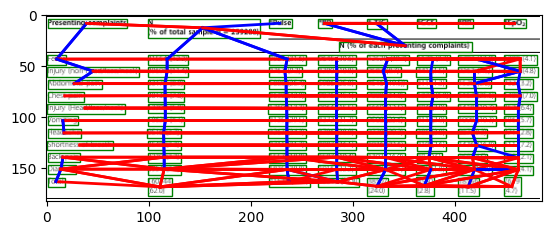

In [16]:
import json
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image

import sys, os
sys.path.insert(0, os.path.abspath('..'))
from utils import xyxy2coco

# Constants for classes
CLASS_NONE = 0
CLASS_HORZ = 1
CLASS_VERT = 2

image_path = r'..\misc\PMC4682394_003_00.png'

bboxes, orig_size = rcnn_forward(
    image_path=image_path,
    checkpoint=r'..\checkpoints\rcnn.pth'
)

bboxes = torch.tensor([xyxy2coco(bbox) for bbox in bboxes])

probs, edge_index = gnet(bboxes, orig_size)
probs, edge_index = probs.to('cpu'), edge_index.to('cpu')

# Step 5: Plotting the bboxes and edges, coloring by predicted class
fig, ax = plt.subplots(1)
image = Image.open(image_path).convert("RGB")
ax.imshow(image)

# Plot the bounding boxes
for bbox in bboxes:
    x, y, w, h = bbox
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)

# Plot the edges
for i, (start, end) in enumerate(edge_index.t()):
    # Get the centers of the start and end bboxes
    bbox1 = bboxes[start]
    bbox2 = bboxes[end]
    
    x1, y1 = bbox1[0] + bbox1[2] // 2, bbox1[1] + bbox1[3] // 2
    x2, y2 = bbox2[0] + bbox2[2] // 2, bbox2[1] + bbox2[3] // 2
    
    # Get the predicted class for the edge
    predicted_class = torch.argmax(probs[i]).item()
    
    # Set the color based on predicted class
    if predicted_class == CLASS_HORZ:
        color = 'red'
    elif predicted_class == CLASS_VERT:
        color = 'blue'
    else:
        color = 'transparent'
    
    if color != 'transparent':  # Only plot if the edge is not class 0
        ax.plot([x1, x2], [y1, y2], color=color, linewidth=2)

plt.show()
